In [1]:
%%capture
import pickle
import numpy as np
import math
import scipy as sp
from EM import EM
from plot import plot
#from EM_individual_params import EM 

### Hyperparameters

In [2]:
bin_size = 60 * 18
num_obs_cutoff = 5

In [3]:
data = pickle.load(open('../Data/unimputed_inr_patient_data.pkl', 'rb'), encoding='latin1')

### Preprocessing
* Choose only the data point that has at least a certain number of observations
* Make each time series (both obs and treatments) start at the time of the first observation
* Bin time series
    * Number of bins is determined by: ceil(bin size / largest last observation time)
    * If there are multiple observations in a bin, average the values
    * If there are multiple treatments of the same kind in a bin, store the number of treatments given
* Convert observations, treatment, static conditions (chronic and age) into matrix form

In [4]:
# select the data based on a cutoff on the number of observations, default to 5
def cutoff_num_obs(data, cutoff):
    new_data = []
    for d in data:
        if d['obs_times'].shape[0] >= cutoff:
            new_data.append(d)
    return new_data

data = cutoff_num_obs(data, num_obs_cutoff)
len(data)

2524

In [5]:
def get_new_time(old_time, starting_time):
    new_time = np.subtract(old_time, starting_time)
    # there might be some treatments before the first observation, discard them
    new_time = np.delete(new_time, np.where(new_time < 0))
    return new_time

# align the time series so that t=0 is where the observation starts
new_data = np.copy(data)
for i, d in enumerate(data):
    starting_time = d['obs_times'][0]
    names = ['obs', 'anticoagulant', 'aspirin', 'nsaid']
    for name in names:
        new_data[i][name + '_times'] = get_new_time(d[name + '_times'], starting_time)
    for j, t in enumerate(d['transfusion_times']):
        if t.shape[0] > 0:
            new_data[i]['transfusion_times'][j] = get_new_time(t, starting_time)
    new_data[i]['transfusion_plasma_times'] = new_data[i]['transfusion_times'][0]
    new_data[i]['transfusion_platelet_times'] = new_data[i]['transfusion_times'][1]                                                                        
    new_data[i]['event_time'] = d['event_time'] - starting_time
data = new_data

In [6]:
def get_bins(bin_size):
    max_obs_times = -np.inf
    for d in data:
        if d['obs_times'][-1] > max_obs_times:
            max_obs_times = d['obs_times'][-1]
    num_bins = math.ceil(max_obs_times / bin_size)
    bins = np.linspace(0, max_obs_times, num_bins)
    return bins

# data is the original data, y_times is obs_times after being aligned at the beginning
# if multiple values are in the same bin, take the average
def binning_y(data, bins):
    y_mtx = np.zeros((len(data), len(bins)-1))
    for i, d in enumerate(data):
        y_binned = np.full(len(bins)-1, np.nan)
        binned_index = np.digitize(d['obs_times'], bins)
        for j in range(1, y_binned.shape[0]):
            index = np.where(binned_index==j)[0]
            if index.shape[0] > 0:
                values = d['obs_y'][index]
                y_binned[j-1] = np.mean(values)
        y_mtx[i, :] = y_binned
    return y_mtx

In [7]:
def binning_X(data, bins):
    X_mtx = np.zeros((len(data), len(bins)-1, 5))
    names = ['nsaid', 'transfusion_plasma', 'transfusion_platelet', 'anticoagulant', 'aspirin']
    for i, d in enumerate(data):
        for k, name in enumerate(names):
            x_binned = np.zeros(len(bins)-1)
            binned_index = np.digitize(d[name + '_times'], bins)
            for j in range(1, x_binned.shape[0]):
                count = np.where(binned_index==j)[0].shape[0]
                x_binned[j-1] = count
            X_mtx[i, :, k] = x_binned
    return X_mtx

In [8]:
bins = get_bins(bin_size)

In [9]:
y = binning_y(data, bins)

In [10]:
last_obs = np.zeros(y.shape[0], dtype=int)
for i in range(y.shape[0]):
    last_obs[i] = np.where(np.invert(np.isnan(y[i, :])))[0][-1] + 1

train_pct = .7
last_train_obs = np.zeros(y.shape[0], dtype=int)
for i in range(y.shape[0]):
    non_nan_idx = np.where(np.invert(np.isnan(y[i, :])))[0]
    last_train_obs[i] = non_nan_idx[int(non_nan_idx.shape[0] * train_pct) - 1] + 1

In [11]:
y_cuttail = {}
for i in range(y.shape[0]):
    y_cuttail[i] = y[i, 0:last_obs[i]]

In [12]:
# the missing percentage of each patient is calculated by dividing the total number of time points between the first
# and last observations by the number of nans between the first and last observations 
missing_pct = 0
for _, obs in y_cuttail.items():
    pct = np.where(np.isnan(obs))[0].shape[0] / obs.shape[0]
    missing_pct += pct
missing_pct /= len(y_cuttail)
missing_pct * 100

25.10570726031089

In [13]:
X = binning_X(data, bins)

In [14]:
def get_c(data):
    c_mtx = np.zeros((len(data), 3))
    for i, d in enumerate(data):
        c = np.concatenate([d['chronic'], d['demographic']], axis=0)
        c_mtx[i, :] = c
    return c_mtx

In [15]:
c = get_c(data)

In [16]:
print('percentage of patients in the data with liver disease: {}'.format\
      (np.nonzero(c[:, 0])[0].shape[0] / c.shape[0] * 100))
print('percentage of patients in the data with sickle cell: {}'.format\
      (np.nonzero(c[:, 1])[0].shape[0] / c.shape[0] * 100))

percentage of patients in the data with liver disease: 8.161648177496037
percentage of patients in the data with sickle cell: 0.554675118858954


Here for each INR observation (say at time t, t is a time point after binning), look at whether there is any treatment given at time t-1 or t-2. If so, calculate the difference between the INR value at time t and the previous observed INR value. If the difference is negative, then we say a treatment has nonincreasing effect. We do this for each of the 4 treatments

In [17]:
for j in range(5):
    treatment_effect = []
    for n in range(y.shape[0]):
        treatment = np.nonzero(X[n, :, j])[0]
        if treatment.shape[0] > 0:        
            inr_index = np.where(np.invert(np.isnan(y[n, :])))[0]
            prev_inr = np.nan
            for i in inr_index:
                prev_one = i-1
                prev_two = i-2
                curr_inr = y[n, i]
                if prev_one in treatment or prev_two in treatment:
                    treatment_effect.append(curr_inr - prev_inr)
                prev_inr = curr_inr
    treatment_effect = np.array(treatment_effect)
    pct_has_effect = np.where(treatment_effect > 0)[0].shape[0] / treatment_effect.shape[0] * 100
    print('Percentage of the {}th treatment with increasing effect on INR: {}'.format(j+1, pct_has_effect))

Percentage of the 1th treatment with increasing effect on INR: 49.01044529961517
Percentage of the 2th treatment with increasing effect on INR: 23.333333333333332
Percentage of the 3th treatment with increasing effect on INR: 21.428571428571427
Percentage of the 4th treatment with increasing effect on INR: 55.137748446013354
Percentage of the 5th treatment with increasing effect on INR: 48.40090657265173


In [18]:
def find_common_elements(a, b):
    count = 0
    if a.shape[0] == 0 or b.shape[0] == 0:
        return count
    for ele in a:
        if ele in b:
            count += 1
    return count

Since anticoagulant stands out as not having obvious nonincreasing effect on INR, we try to see if its effect may interact with the effects of other treatments

In [19]:
atc_total = 0
with_ns = 0
with_plasma_tf = 0
with_platelet_tf = 0
with_asp = 0
for n in range(y.shape[0]):
    atc = np.nonzero(X[n, :, 3])[0]
    atc_total += atc.shape[0]
    if atc.shape[0] > 0:
        ns = np.nonzero(X[n, :, 0])[0]
        plasma_tf = np.nonzero(X[n, :, 1])[0]
        platelet_tf = np.nonzero(X[n, :, 2])[0]
        asp = np.nonzero(X[n, :, 4])[0]
        with_ns += find_common_elements(atc, ns)
        with_plasma_tf += find_common_elements(atc, plasma_tf)
        with_platelet_tf += find_common_elements(atc, platelet_tf)
        with_asp += find_common_elements(atc, asp)
print('anticoagulant is administered {}% times with nsaid'.format(with_ns / atc_total * 100))
print('anticoagulant is administered {}% times with plasma transfusion'.format(with_plasma_tf / atc_total * 100))
print('anticoagulant is administered {}% times with platelet transfusion'.format(with_platelet_tf / atc_total * 100))
print('anticoagulant is administered {}% times with aspirin'.format(with_asp / atc_total * 100))

anticoagulant is administered 14.735082035740414% times with nsaid
anticoagulant is administered 0.28216114536524195% times with plasma transfusion
anticoagulant is administered 0.0365764447695684% times with platelet transfusion
anticoagulant is administered 17.760476538823283% times with aspirin


### Analysis
* Bin size = 18 hrs, ~25% missingness; 15 -> 35%; 12 -> 45% 
* Cutoff = 5, ~2500; 7--> 1400; 10 -> 600
* Changing bin size doesn't seem to change performance much, i.e. similar coefficients.
* Changing cutoff changes the last treatment coefficients.
* Informative priors are important. Chronics and age coefficients are negative if priors are uninformative. The distributions don't show obvious shift so those coefficients might be hard to learn. But with N(-.1, small noise) prior the coefficients become positive
* Treatment coefficients for transfusion and anticoagulants are usually reasonable (negative, the first one being more negative than the second, indicates that the more recent treatment has greater effect). But coefficients of nsaid are always positive. Could be because the effect of treatment is difficult to identify based on the data (see above analysis and in many plots trajectory rise or stay constant after treatment is given)
* The test setting that gives the most "reasonable" coeffcients is cutoff = 5, bin size = 18
* The plots show that the predicted trajectory usually dips slightly after some treatments, and remain flat if no treatment is observed. The slight dips corresponds to the relatively small coefficients learned by the model.

### Reasons for Errors
* Assume the a single set of parameters generate all the data. This assumption could be violated since:
    1. Each patient respond to treatment differently
    2. Different treatment and chronic conditions may have various interaction effects on different individuals
* After changing treatment coefficients to be on individual level, the average coefficients are similar to the case of population level coefficients. The fit on some plots improve slightly but not much.  
* Assume observed value is well explained by the treatment and chronic variable. whereas in reality there might be other variable that contributes to the observed
* Assume linear transition, emission and treatment/chronic effects
* Seeing from the data, treatments don't seem to show clear effects on INR, from plots and from calculations.

18, 10

array([[ 0.0936003 , -0.08078284, -0.18641289,  0.13891277],
       [ 0.06990001, -0.04344261, -0.03366263,  0.02030954]])

array([0.74823636, 0.58981125, 0.05654957])

15, 10
array([[ 0.13456621, -0.08554308, -0.22767711,  0.18810093],
       [ 0.03645638, -0.06892858, -0.02922591,  0.09172675]])

array([0.78634843, 0.46003341, 0.05972339])

12, 10
array([[ 0.10666655, -0.08696049, -0.26940387,  0.19050202],
       [ 0.05440813, -0.05472304, -0.13251392,  0.14978341]])

array([0.66177451, 0.44433981, 0.05699542])

18, 5
array([[ 0.09196221, -0.08517231, -0.15410302, -0.02786158],
       [ 0.01896725, -0.04654681, -0.00878168, -0.02707853]])

array([0.67258056, 0.97197241, 0.05415181])

In [20]:
em = EM(y, X, c, 2, 0, .7)

In [21]:
%%time
em.run_EM(5)

max iterations: 5 reached
CPU times: user 4.59 s, sys: 221 ms, total: 4.81 s
Wall time: 2 s


In [22]:
np.average(em.A, axis = 0)

array([-0.08714433, -0.16101652, -0.21281325, -0.27187762, -0.22237273])

In [23]:
em.A

array([[-0.0436084 , -0.17423719, -0.1832038 , -0.31498846, -0.18508718],
       [-0.13068025, -0.14779585, -0.2424227 , -0.22876678, -0.25965829]])

In [24]:
em.b

array([0.0045587 , 0.20019193, 0.01479676])

In [25]:
em.sigma_1

0.9697566677546948

In [26]:
em.sigma_2

1.3953372446462318

In [27]:
em.sigma_0

0.029863675726914563

In [28]:
em.init_z

1.1608758754648418

In [34]:
em.c

array([[ 0.,  0., 56.],
       [ 0.,  0., 89.],
       [ 0.,  0., 88.],
       ...,
       [ 0.,  0., 74.],
       [ 0.,  0., 72.],
       [ 0.,  0., 86.]])

Patient 63


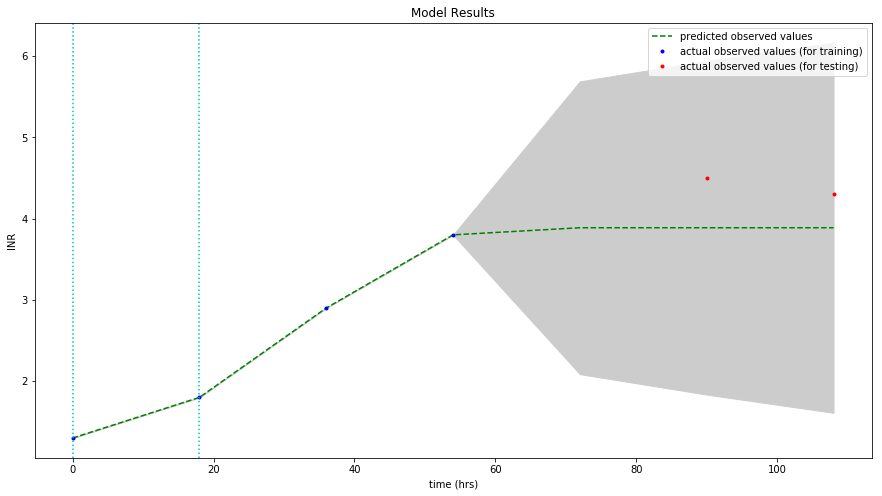

Patient 748


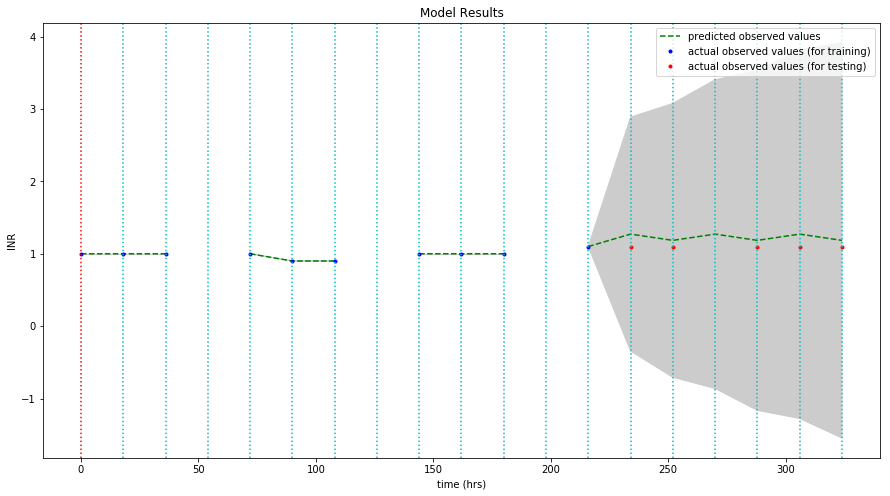

Patient 951


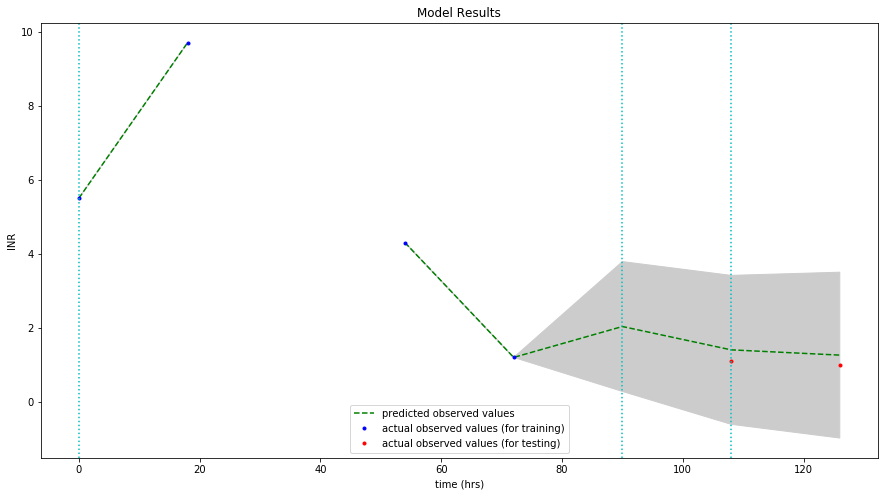

Patient 1749


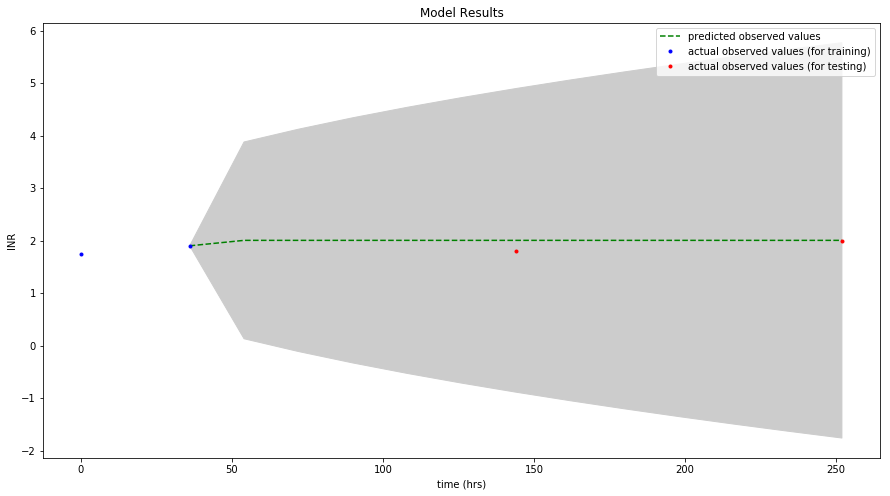

Patient 106


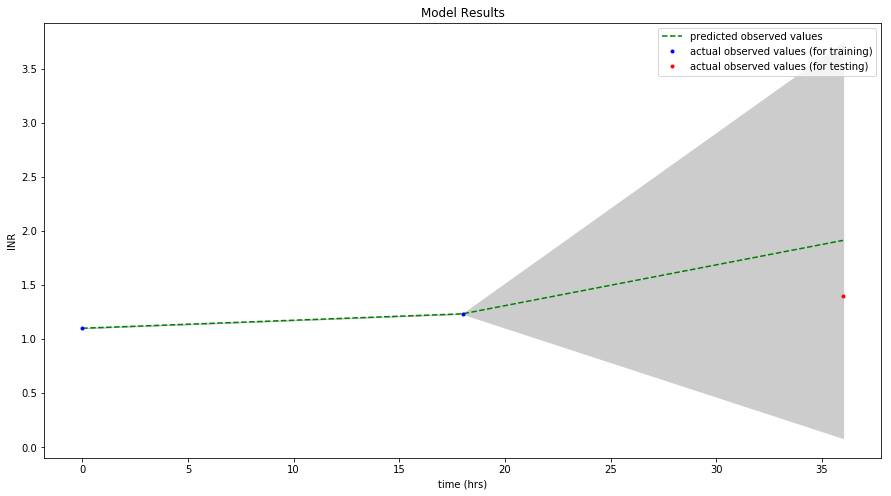

Patient 965


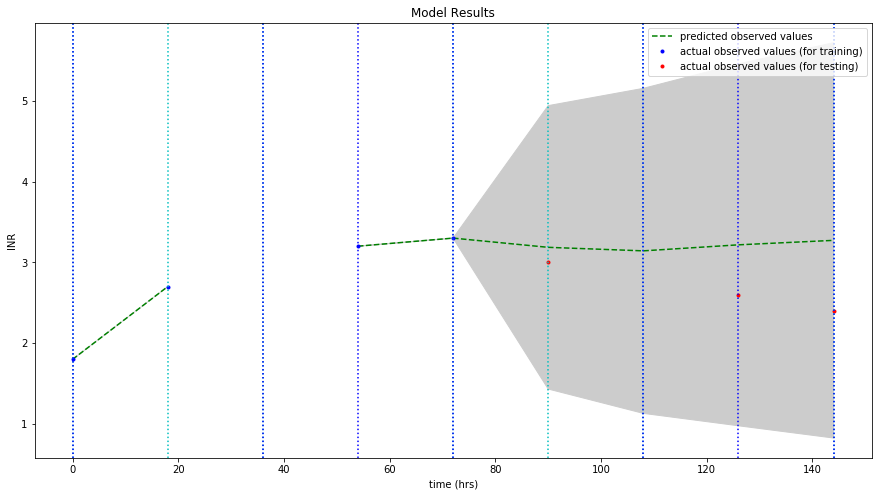

Patient 2316


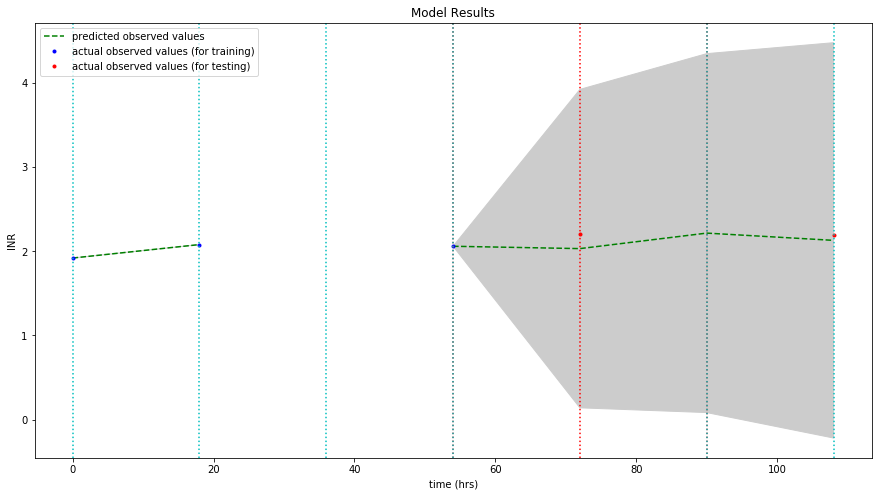

Patient 2044


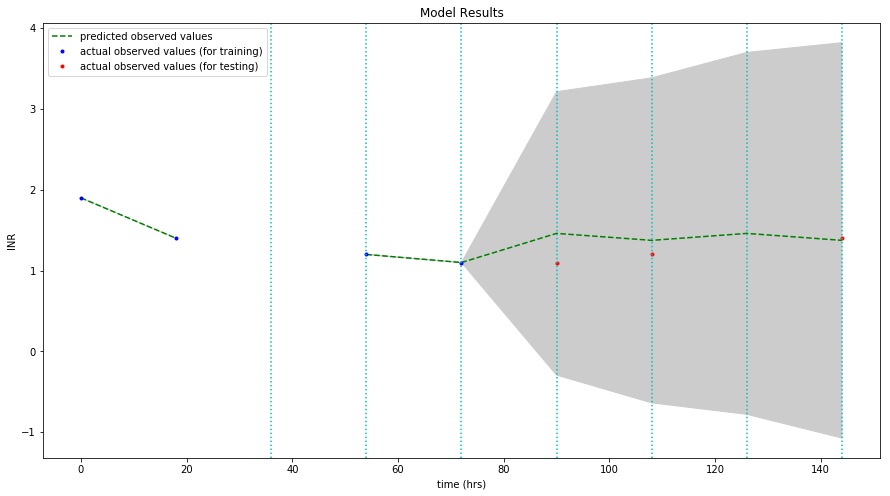

Patient 2509


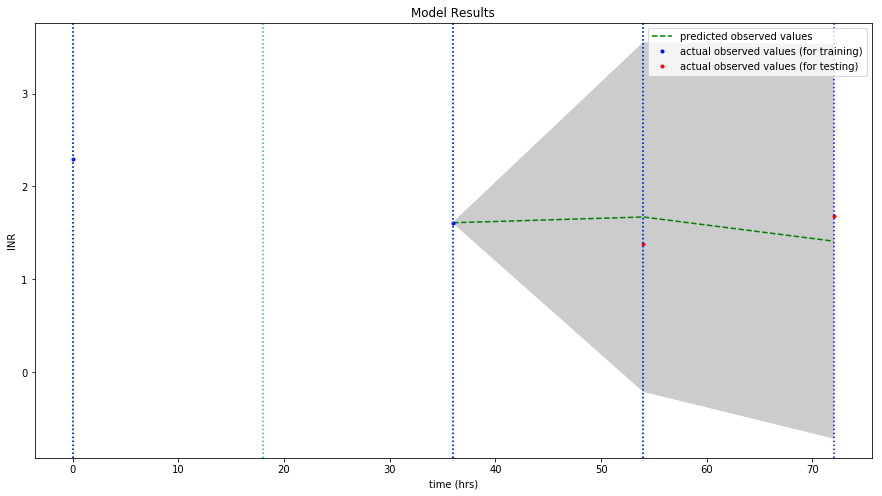

Patient 1473


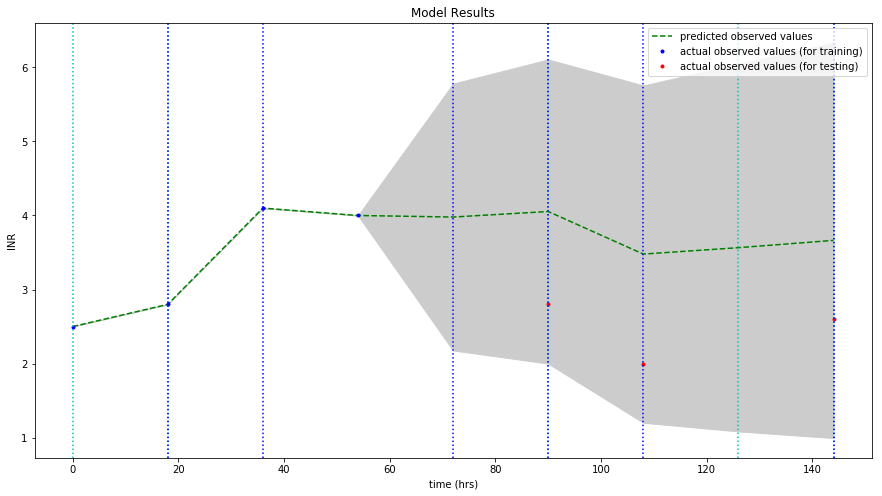

Patient 2155


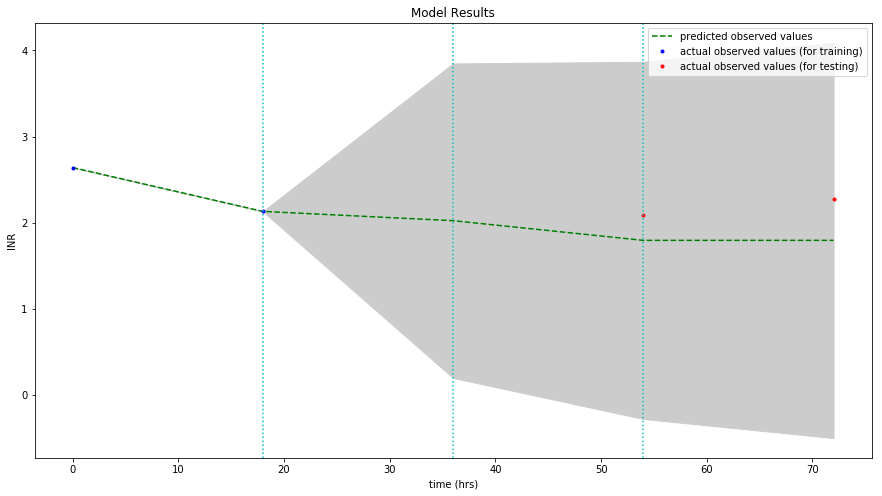

Patient 2091


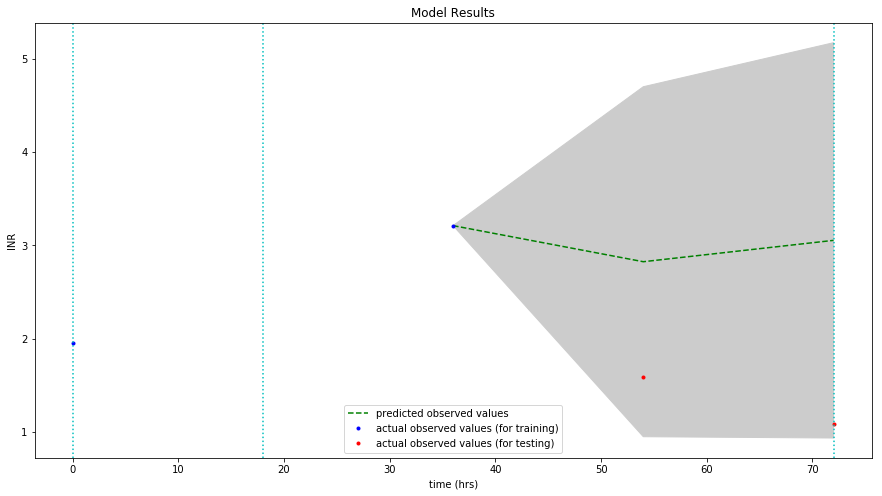

Patient 1636


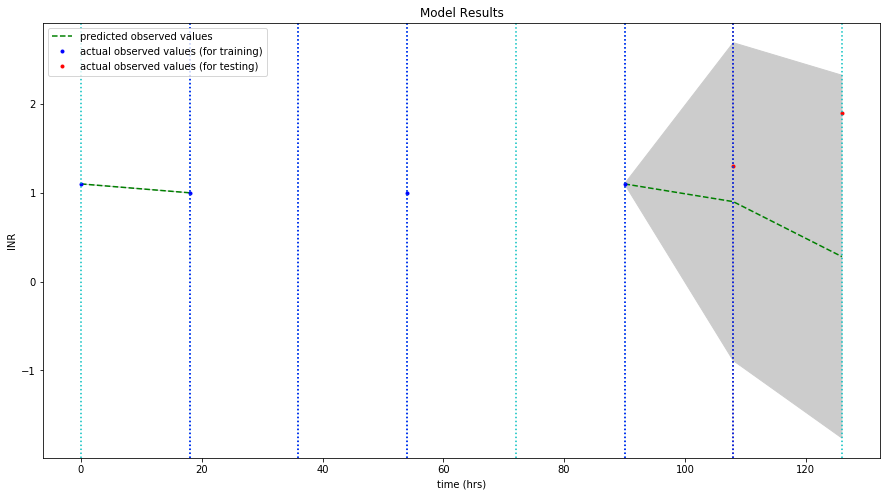

Patient 2523


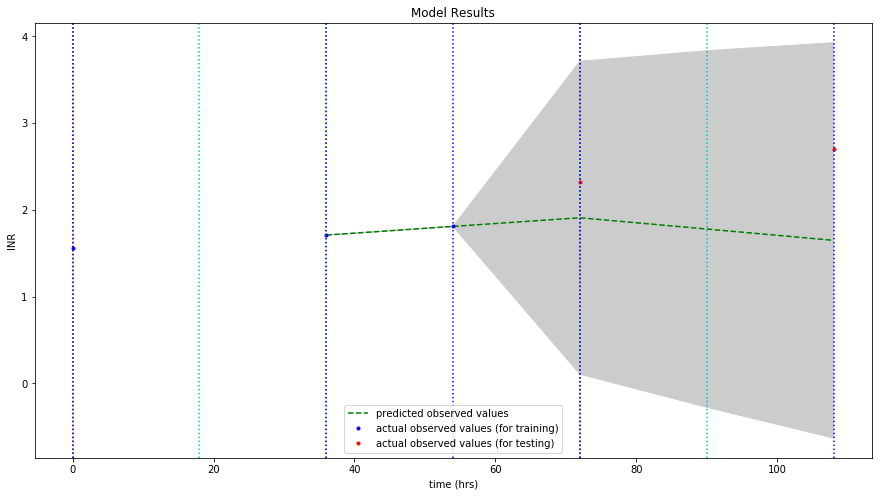

Patient 919


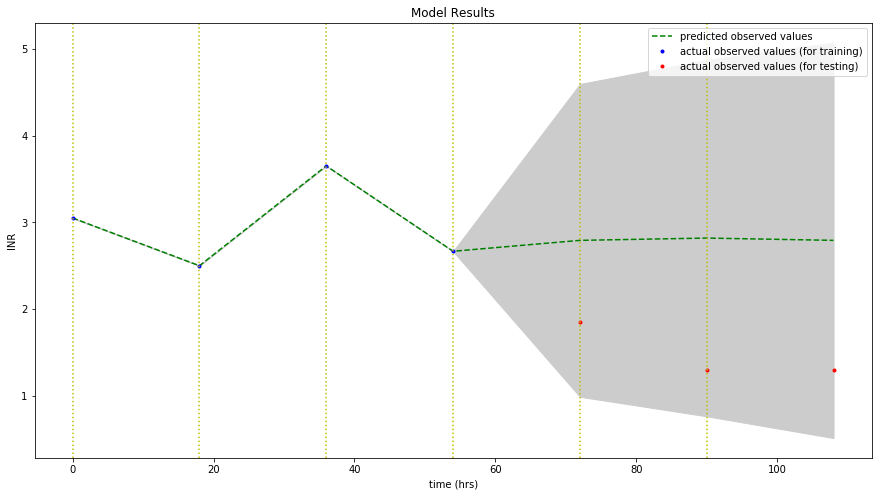

Patient 1413


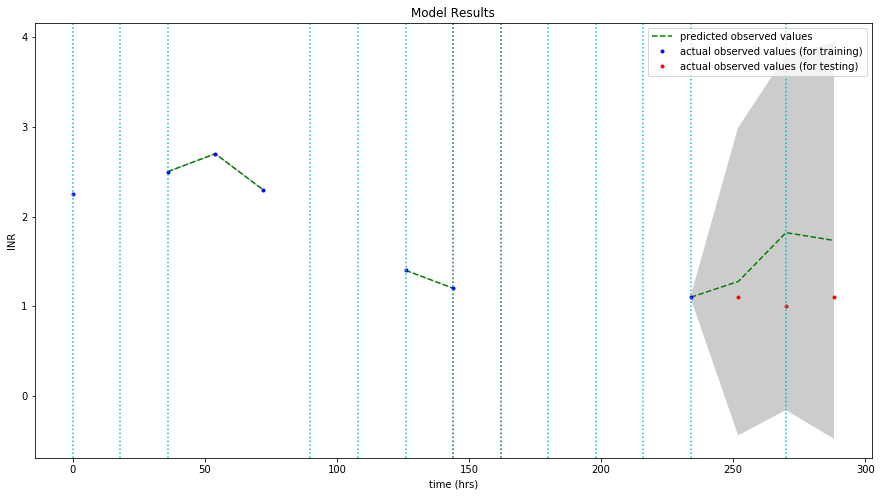

Patient 1871


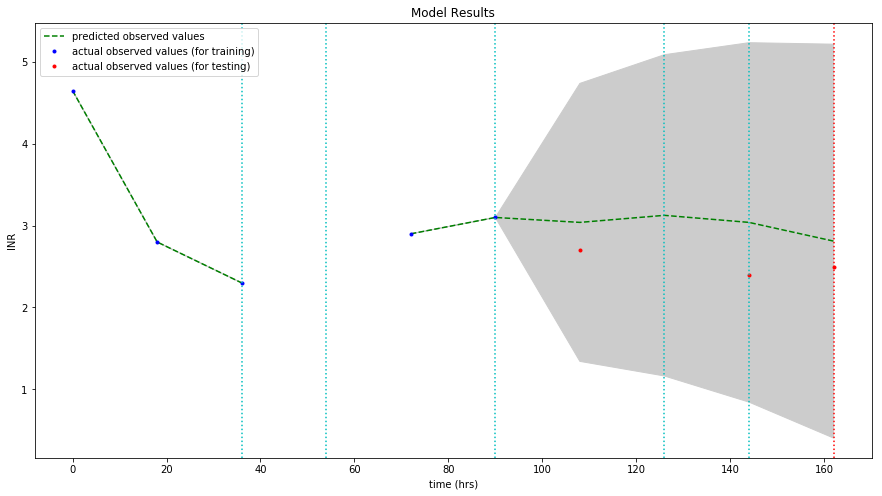

Patient 1722


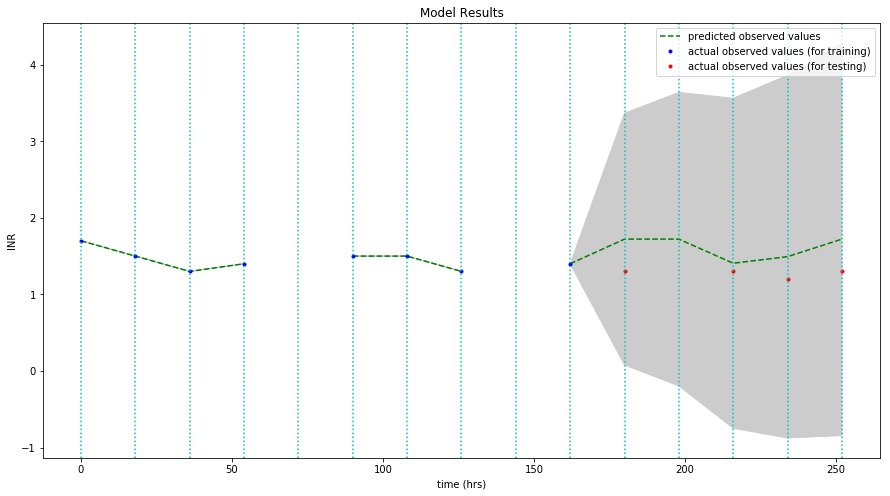

Patient 2359


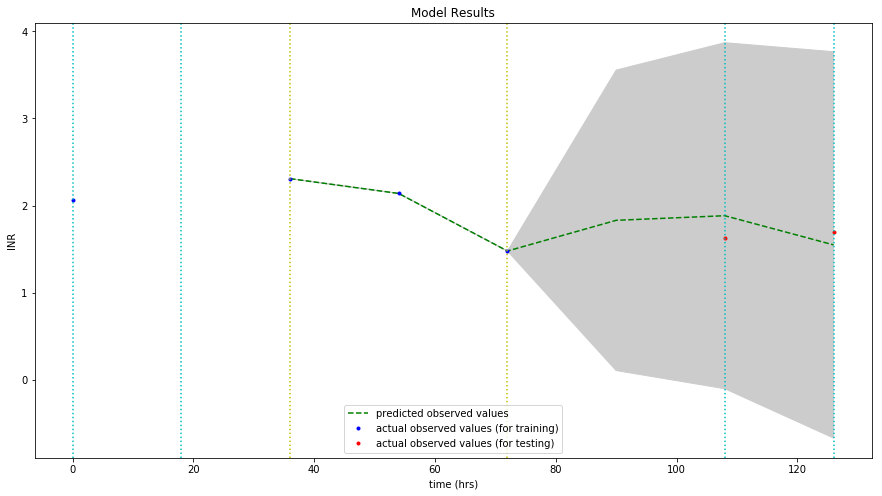

Patient 724


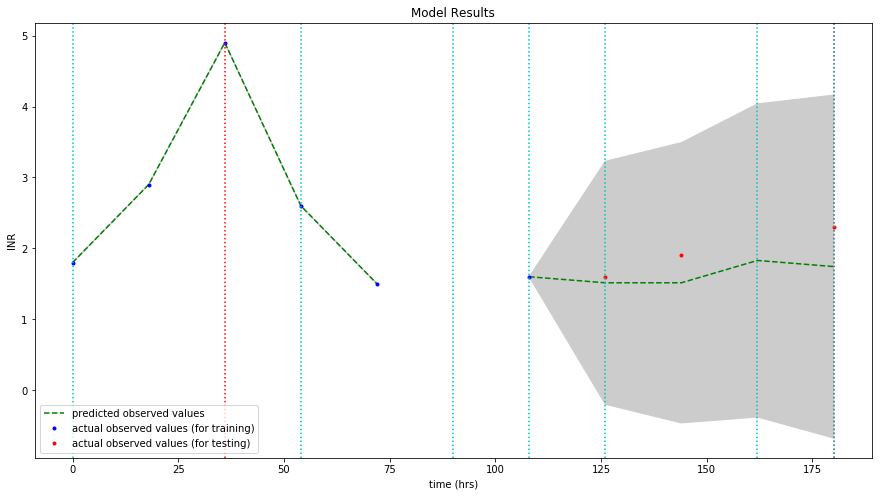

Patient 574


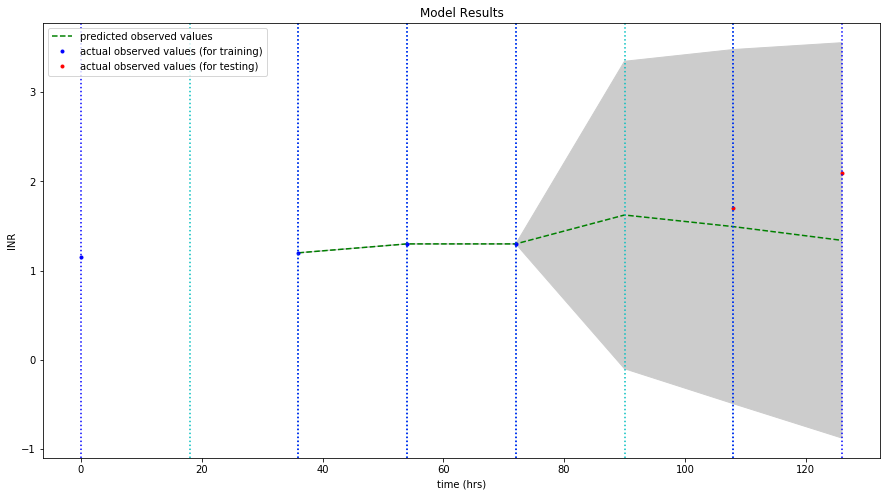

Patient 1196


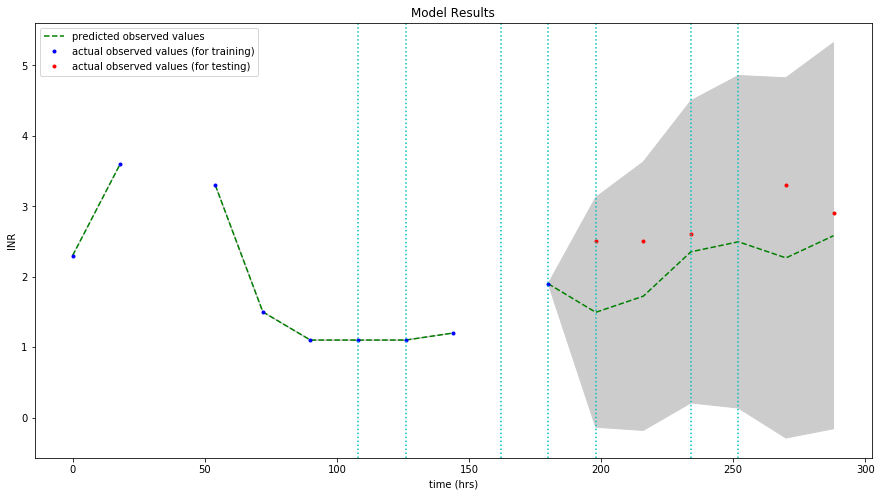

Patient 640


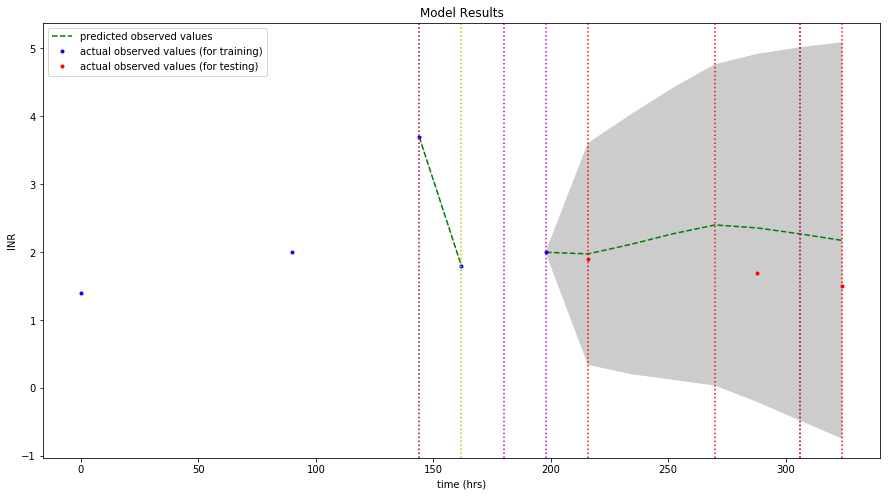

Patient 2194


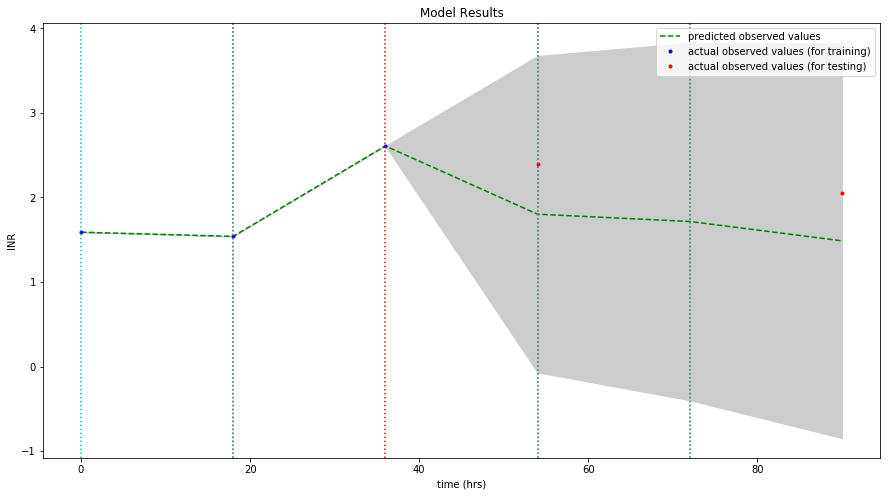

Patient 1693


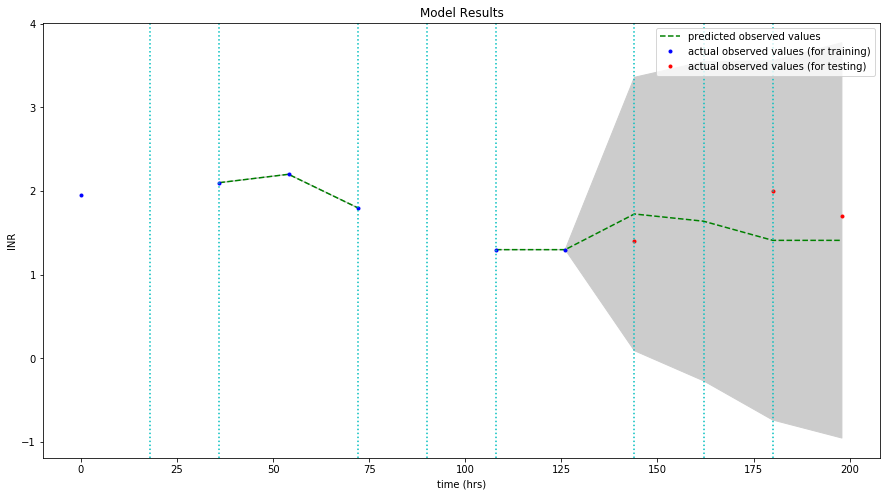

Patient 1636


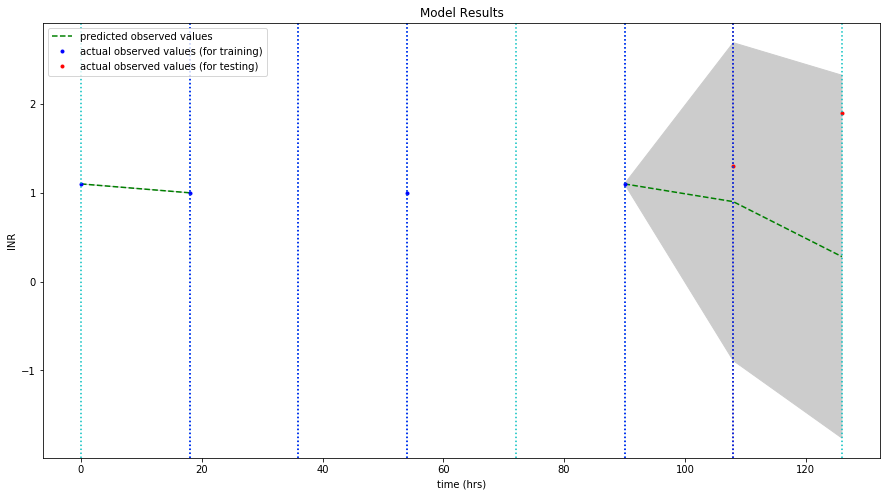

Patient 1888


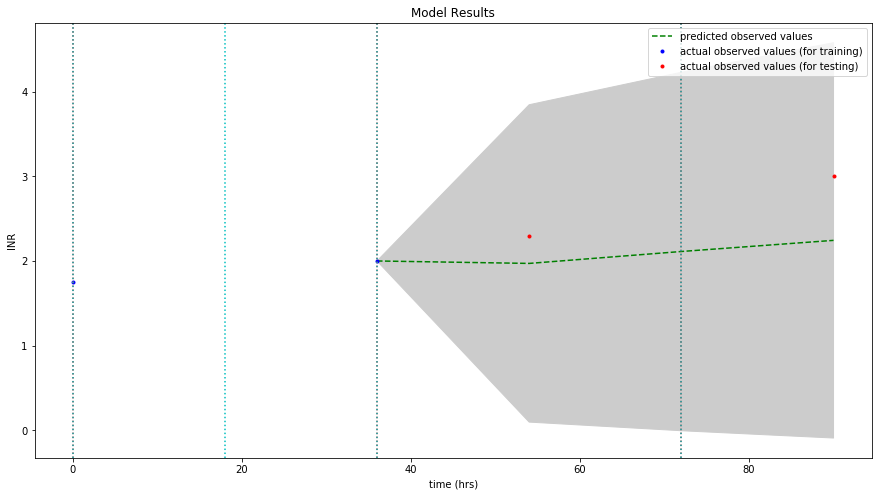

Patient 850


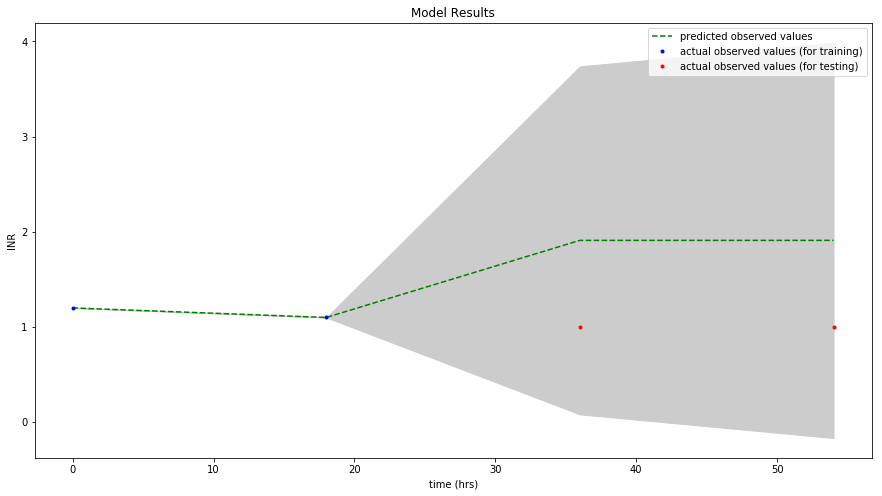

Patient 1850


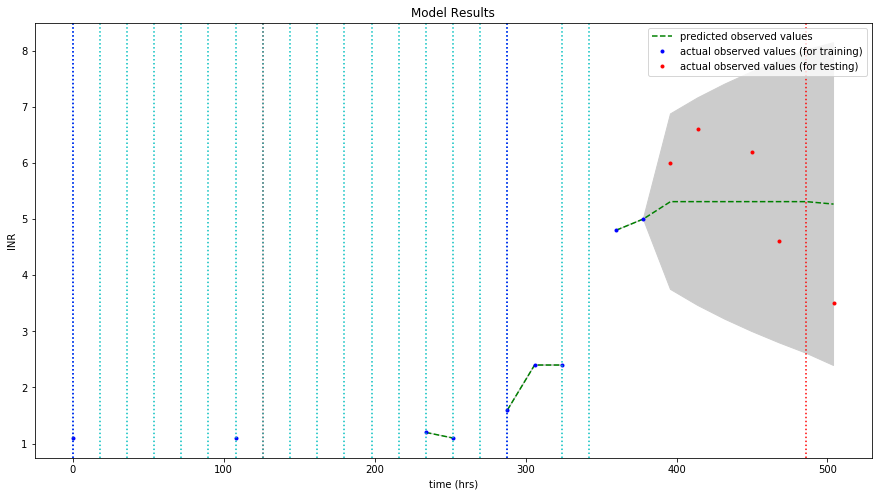

Patient 1850


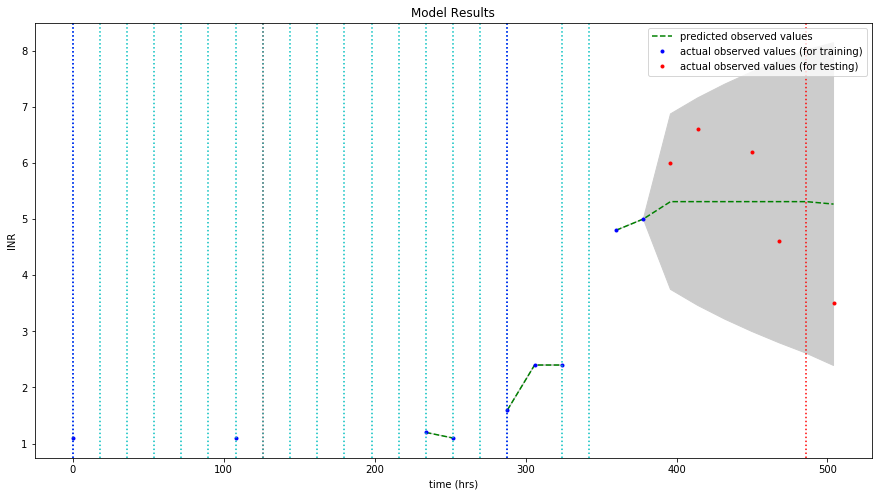

Patient 2057


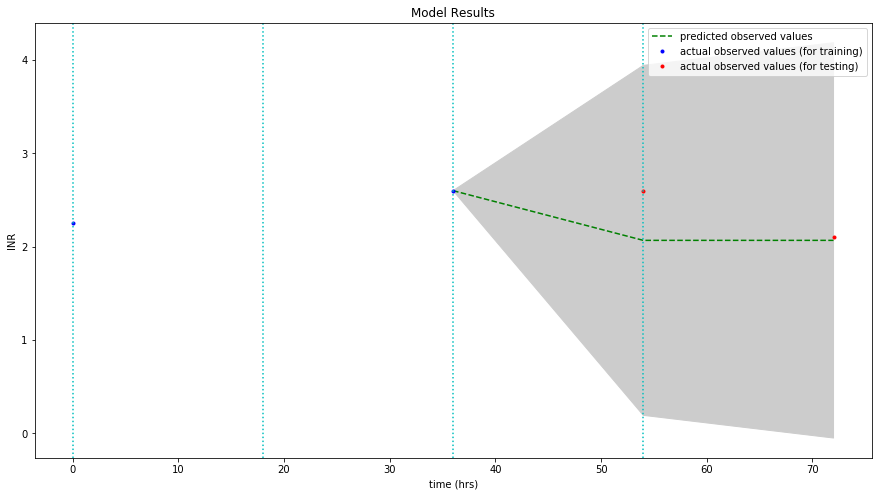

Patient 1479


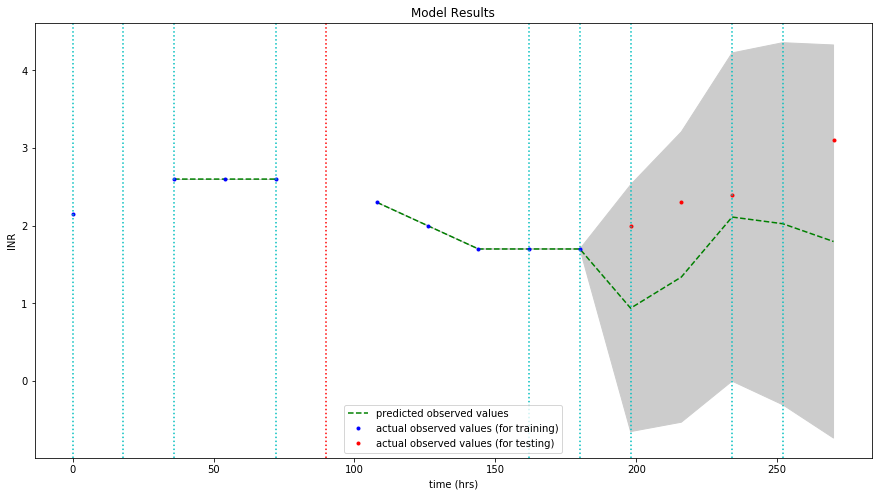

Patient 1128


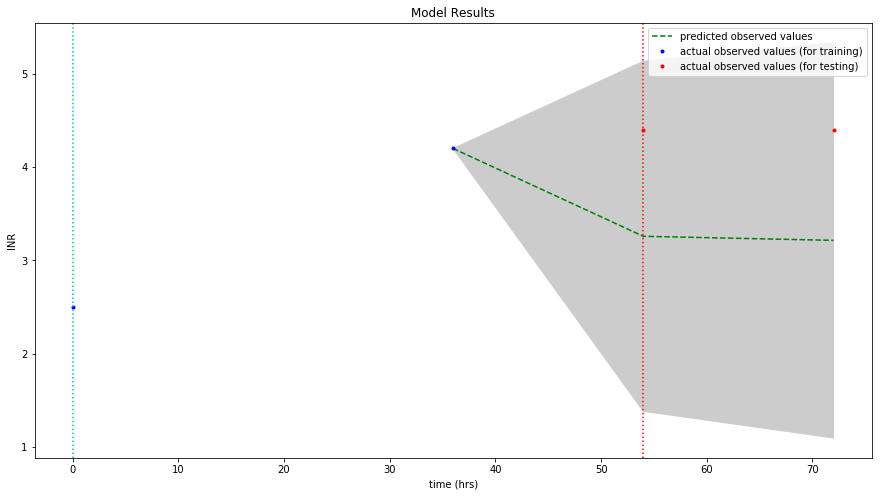

Patient 790


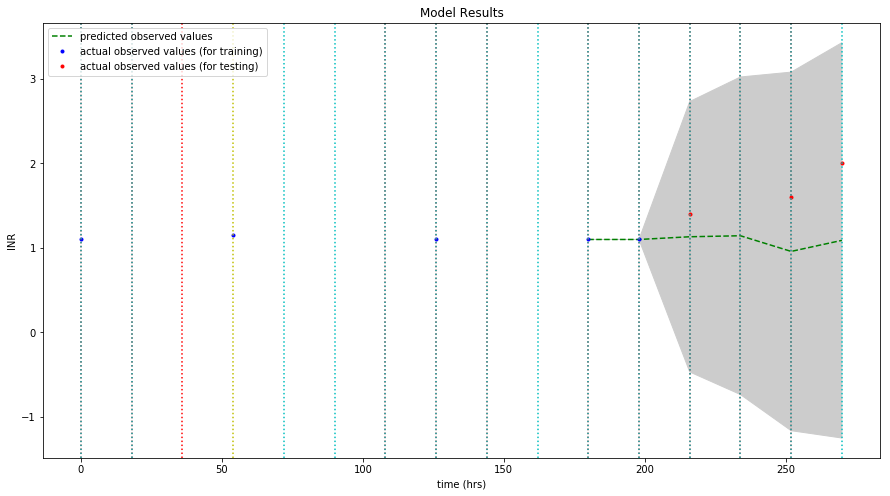

Patient 2100


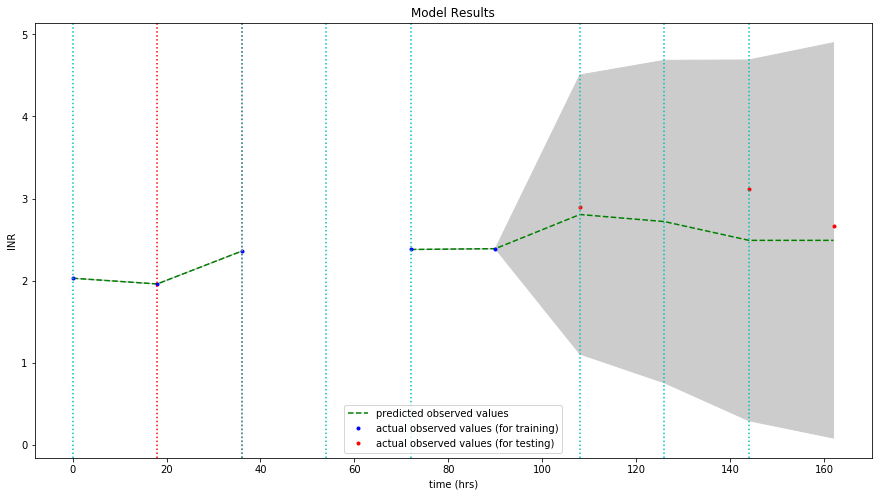

Patient 1235


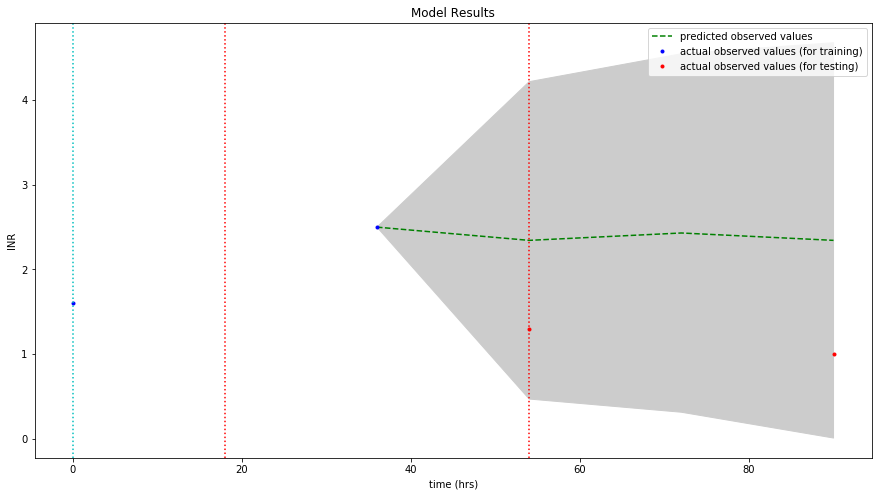

Patient 642


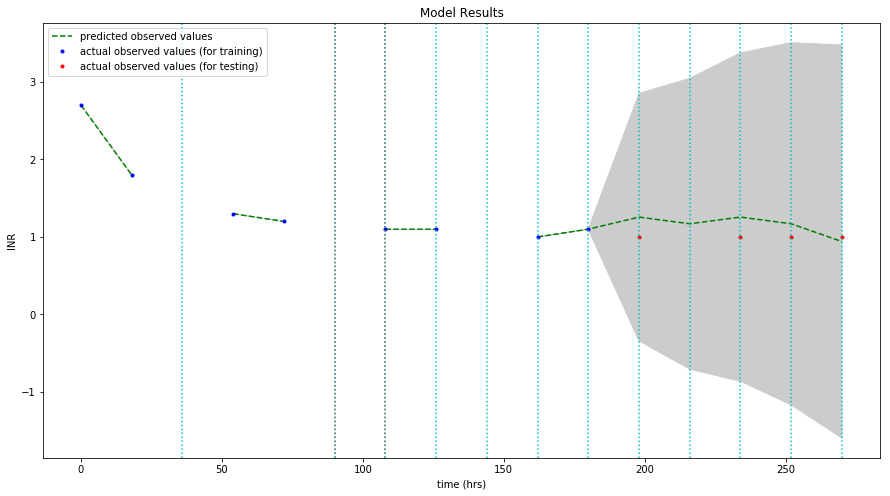

Patient 1717


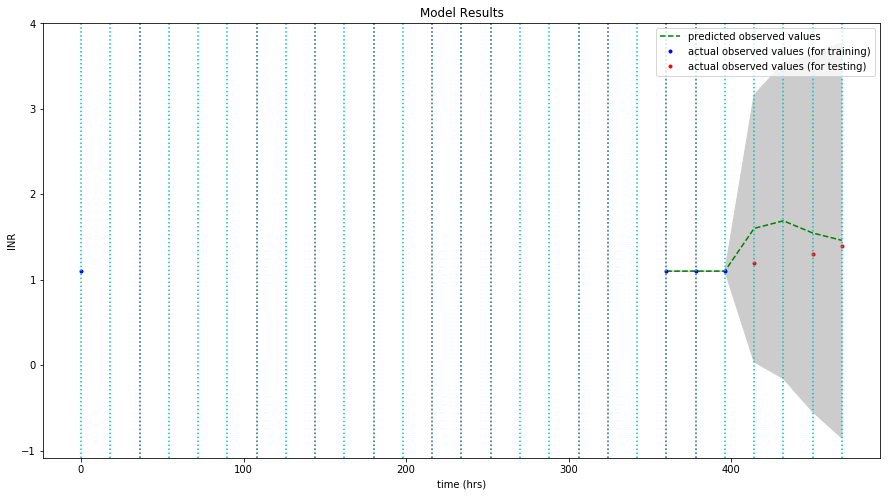

Patient 2281


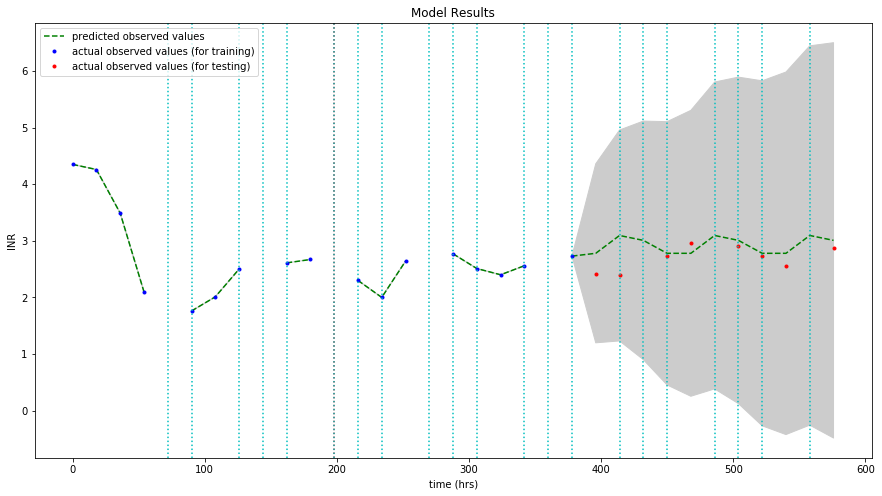

Patient 136


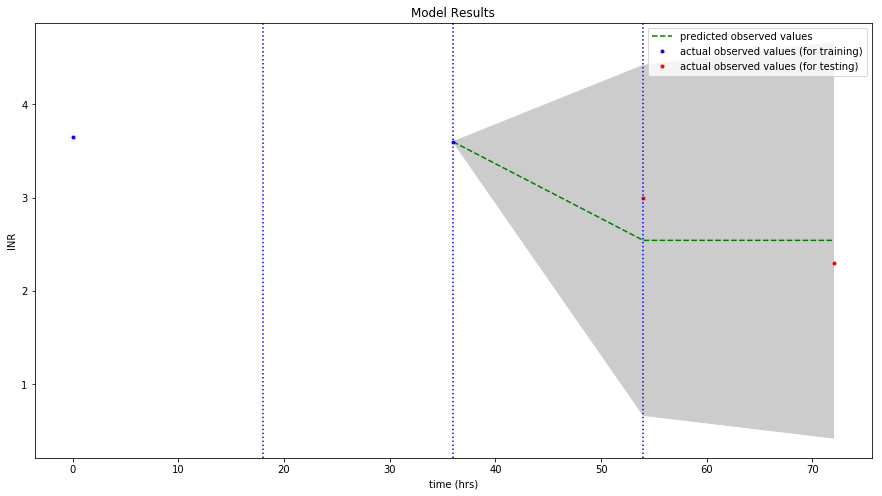

Patient 1921


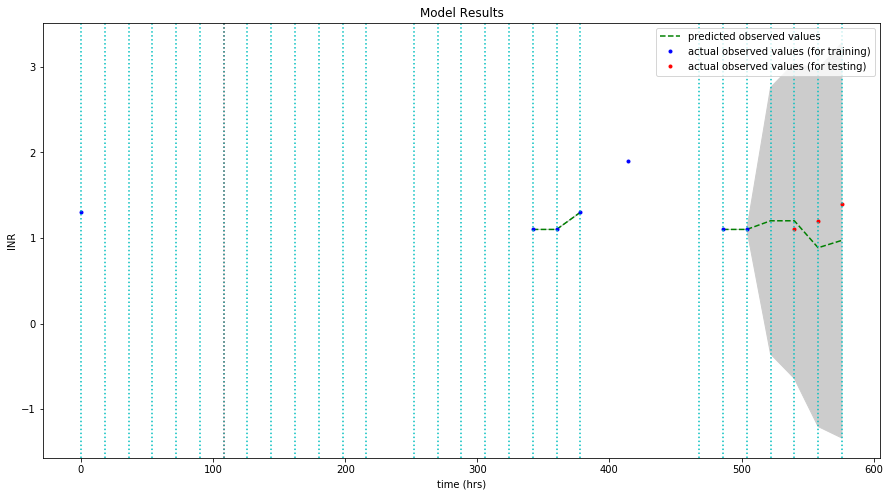

Patient 1119


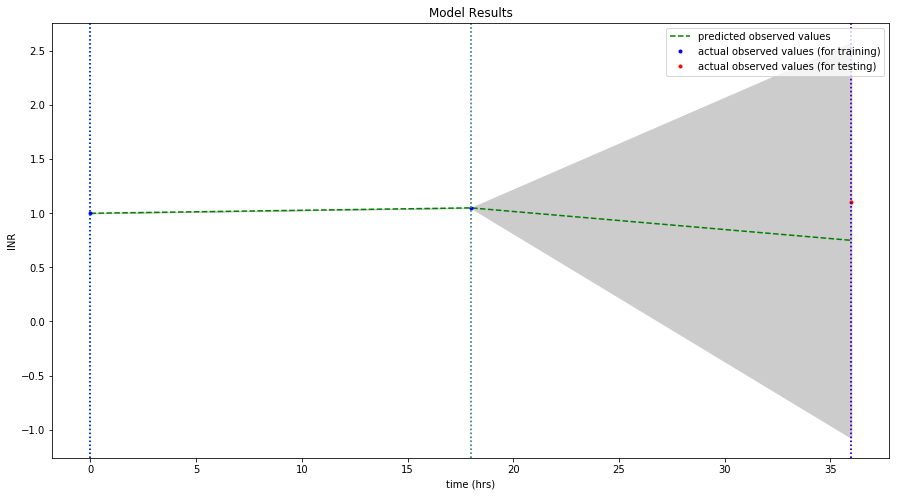

Patient 1946


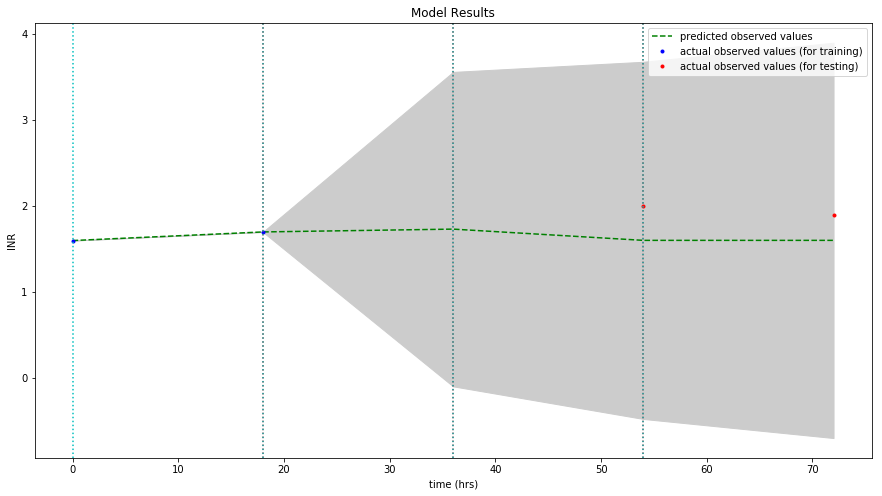

Patient 2320


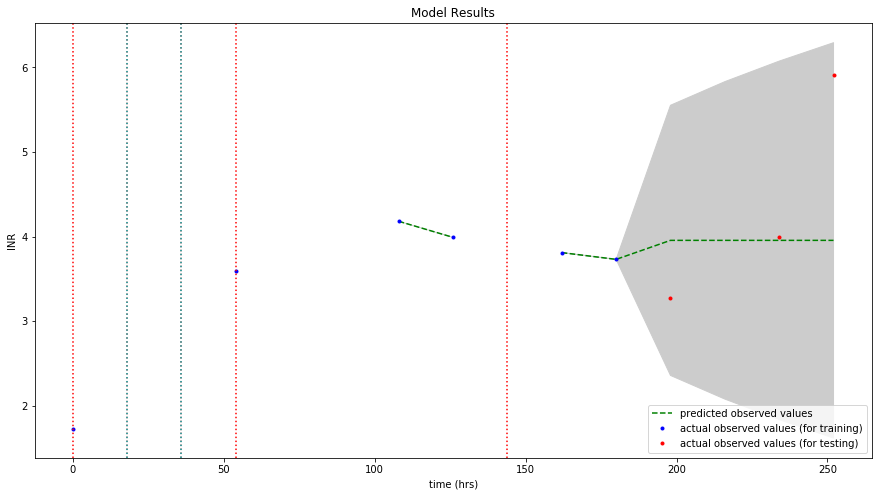

Patient 156


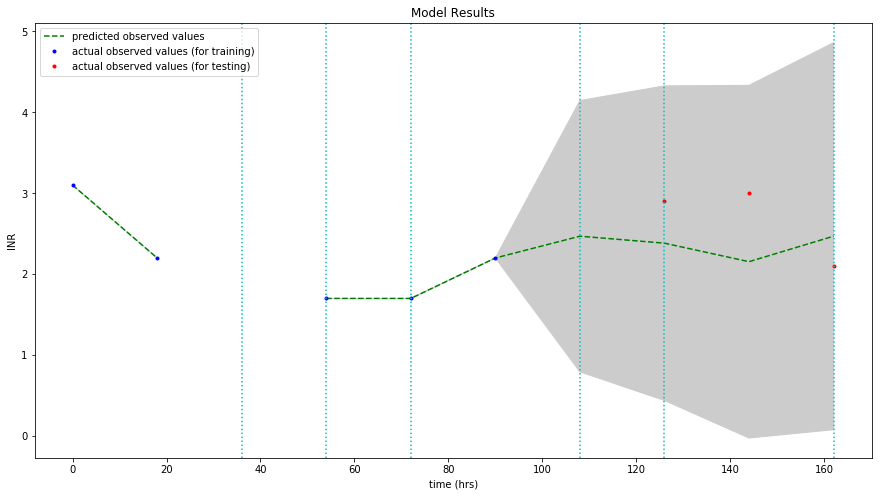

Patient 696


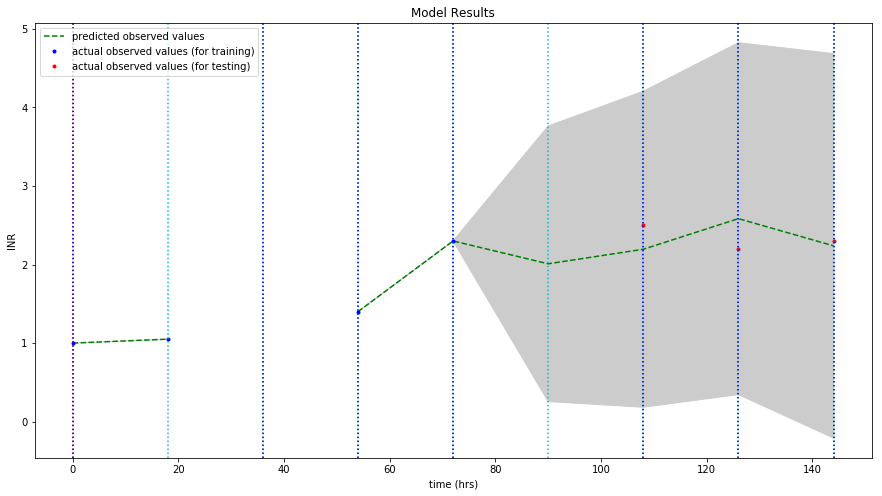

Patient 612


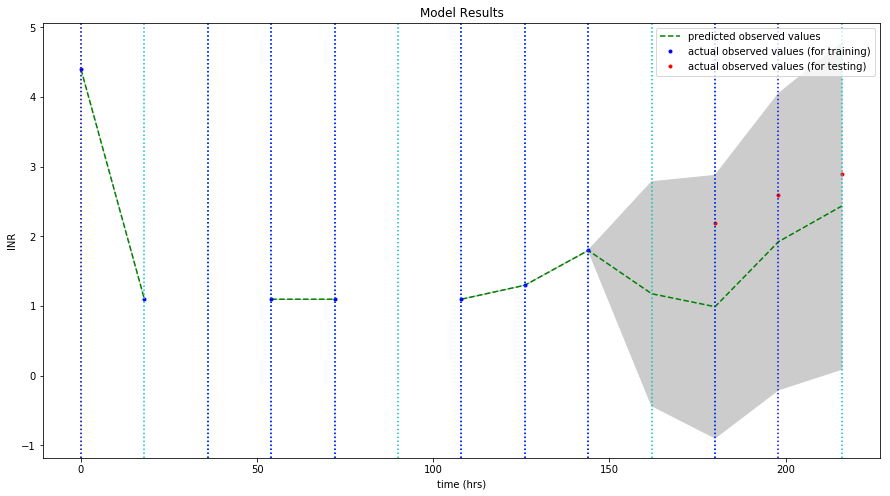

Patient 2312


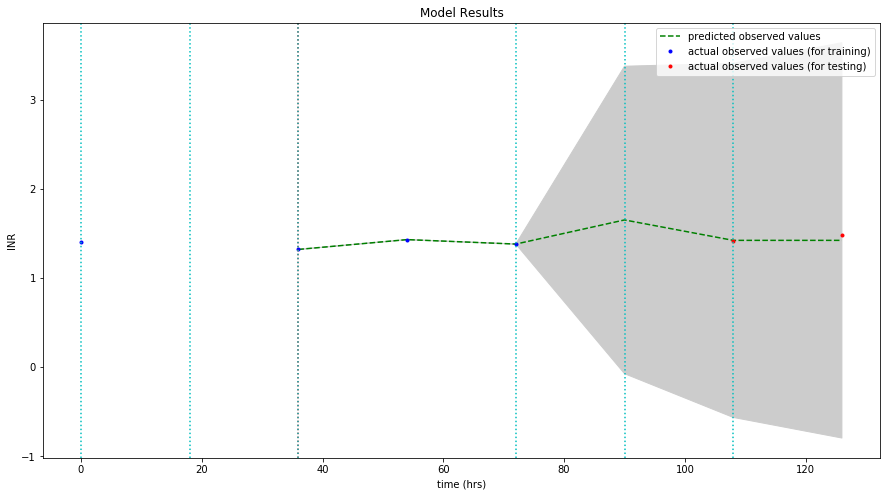

Patient 2470


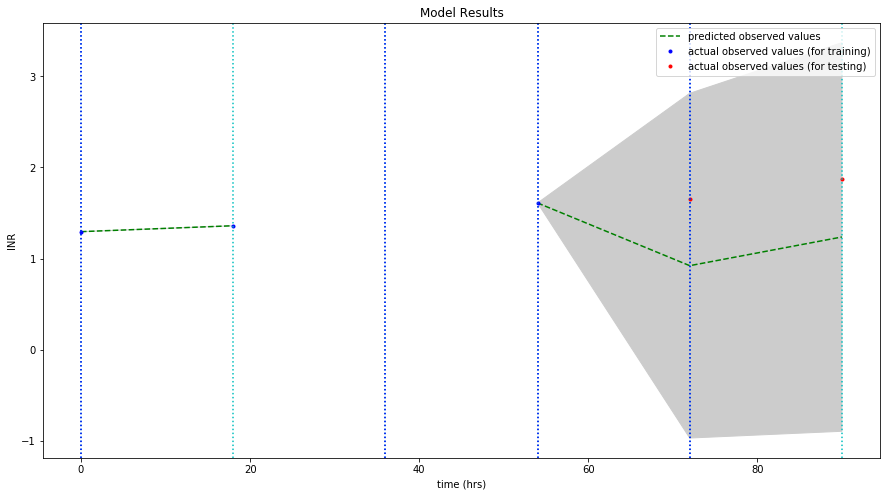

Patient 1294


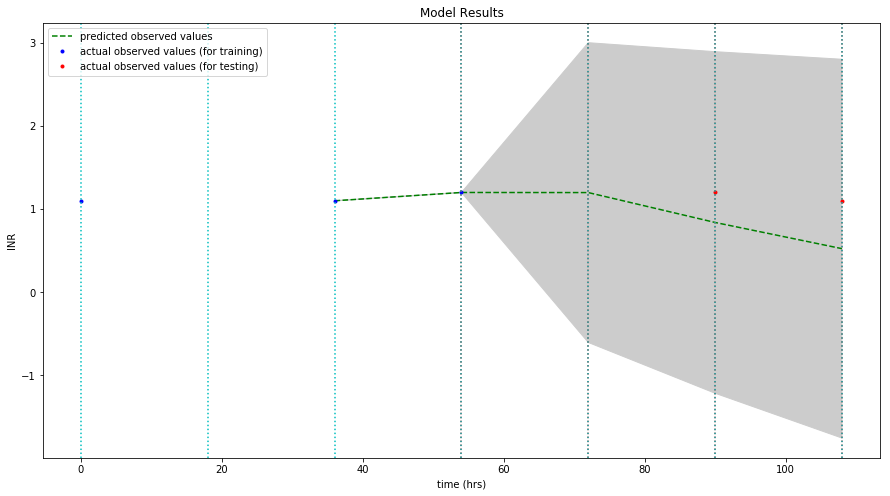

In [30]:
random_patients = np.random.randint(0, y.shape[0], size=50)
for i in random_patients:
    plot(em, i, bin_size, False)